In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01"]

device = torch.device("cpu")
dtype = torch.float32

In [3]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences_oh(seq, pseudo_count=0.0) for seq in sequences_oh])
fi = torch.stack(freq_single_tuple).to(device=device, dtype=dtype)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple).to(device=device, dtype=dtype)     # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple).to(device=device, dtype=dtype)
n_rounds, L, q = fi.size()

In [401]:
import importlib
importlib.reload(indep_sites)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/training.py'>

In [429]:
k = torch.zeros(L, q, dtype=dtype, device=device)
h = torch.zeros(L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)

selected_modes = torch.BoolTensor([[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(indep, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [430]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [431]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [432]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [433]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 50

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
               callbacks=callbacks, log_weights=log_weights)

 0.00%[                               ] Epoch: 0/50 [00:00, ?it/s]

In [434]:
n_sweeps = 10
lr = 0.001
max_epochs = 400

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
               callbacks=callbacks, log_weights=log_weights)

 0.00%[                              ] Epoch: 0/400 [00:00, ?it/s]

In [441]:
n_sweeps = 10
lr = 0.0005
max_epochs = 1000

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
               callbacks=callbacks, log_weights=log_weights)

 0.00%[                             ] Epoch: 0/1000 [00:00, ?it/s]

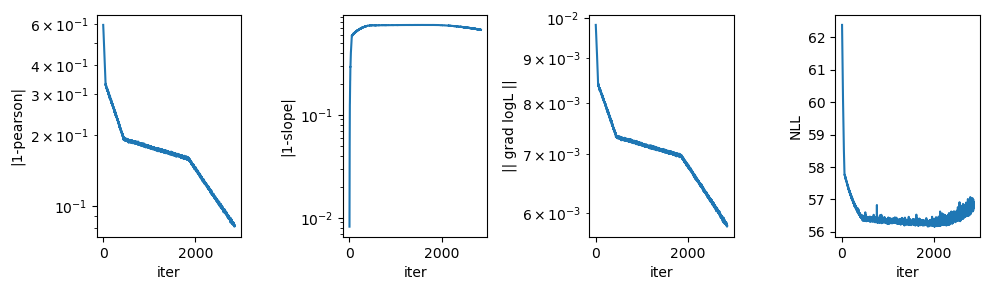

In [442]:
callbacks[0].plot();

In [424]:
params = indep_sites.init_parameters(fi)
params["bias_Ns0"] = torch.zeros(L, q, dtype=dtype, device=device)
params["bias_ps"] = torch.zeros(L, q, dtype=dtype, device=device)
params, history = indep_sites.train(
    fi=fi,
    total_reads=total_reads, 
    params=params,
    lr=lr,
    max_epochs=1200,
    target_error=0,
    history=indep_sites.init_history(),
    progress_bar=False)

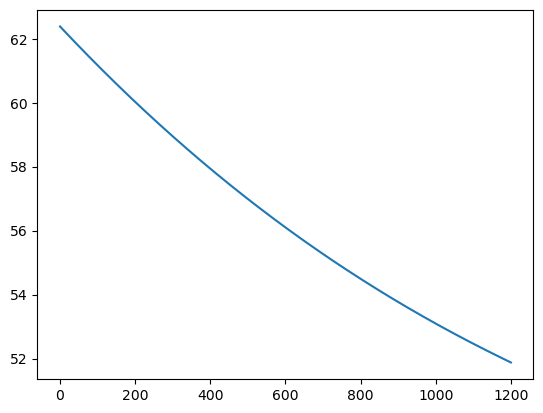

In [425]:
plt.plot([-l for l in history["log-likelihood"]])

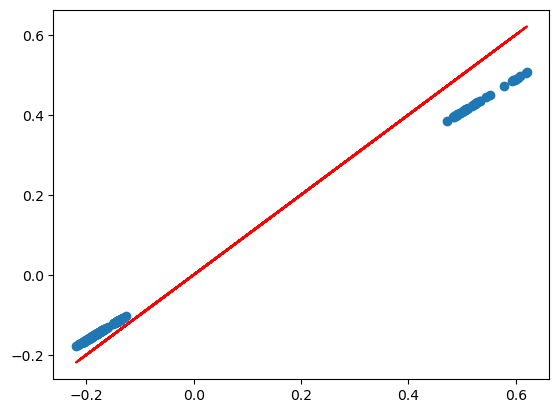

In [443]:
x = model.round_zero.h.detach()
y = params["bias_Ns0"]
x -= x.mean(1, keepdim=True)
y -= y.mean(1, keepdim=True)
plt.scatter(x, y)
plt.plot(x, x, color='r');

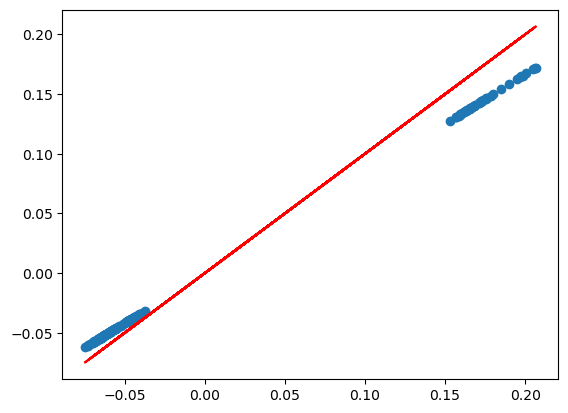

In [444]:
x = model.selection.modes[0].h.detach()
y = params["bias_ps"]
x -= x.mean(1, keepdim=True)
y -= y.mean(1, keepdim=True)
plt.scatter(x, y)
plt.plot(x, x, color='r');

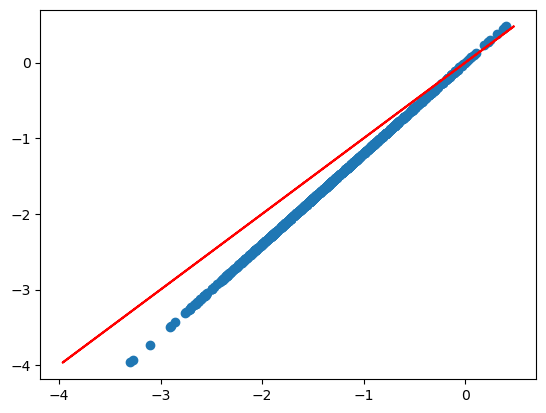

In [445]:
x = chains[0][:1000]
plt.scatter(
    indep_sites.compute_energy(x, {"bias": params["bias_ps"]}).detach(), 
    model.selection_energy_at_round(x, 1).detach()
)
plt.plot(model.selection_energy_at_round(x, 1).detach(), model.selection_energy_at_round(x, 1).detach(), color='r')